In [1]:
import pandas as pd
import numpy as np
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import *
# 核心模型使用第三方库
from catboost import CatBoostClassifier
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
import lightgbm as lgb
# 交叉验证所使用的第三方库
from sklearn.model_selection import StratifiedKFold, KFold
# 评估指标所使用的的第三方库
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
# 忽略报警所使用的第三方库
import warnings
warnings.filterwarnings('ignore')
import mvtpy

D:\Download\Anaconda\neirong\lib\site-packages\setuptools\_importlib.py:23: UserWarning: `importlib-metadata` version is incompatible with `setuptools`.
This problem is likely to be solved by installing an updated version of `importlib-metadata`.
  warnings.warn(msg)  # Ensure a descriptive message is shown.
D:\Download\Anaconda\neirong\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data_2 = pd.read_csv("t2.csv")

In [3]:
data_1 = pd.read_csv("t1.csv")

In [4]:
def get_dig(str):
    return str[:2]
# data_2 = pd.read_csv("t2.csv")

#data_2【17】【19】
data_2['文物编号'] = data_2['文物采样点'].apply(get_dig)

data_2['文物编号'] = data_2['文物编号'].astype(int)

data_2 = pd.merge(data_2,data_1[['文物编号','类型','表面风化']], how='left', on='文物编号')


In [5]:
data_2

,文物采样点,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2),文物编号,类型,表面风化
0,01,69.33,NaN,9.99,6.32,0.87,3.93,1.74,3.87,NaN,NaN,1.17,NaN,NaN,0.39,1,高钾,无风化
1,02,36.28,NaN,1.05,2.34,1.18,5.73,1.86,0.26,47.43,NaN,3.57,0.19,NaN,NaN,2,铅钡,风化
2,03部位1,87.05,NaN,5.19,2.01,NaN,4.06,NaN,0.78,0.25,NaN,0.66,NaN,NaN,NaN,3,高钾,无风化
3,03部位2,61.71,NaN,12.37,5.87,1.11,5.50,2.16,5.09,1.41,2.86,0.70,0.10,NaN,NaN,3,高钾,无风化
4,04,65.88,NaN,9.67,7.12,1.56,6.44,2.06,2.18,NaN,NaN,0.79,NaN,NaN,0.36,4,高钾,无风化
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,54严重风化点,17.11,NaN,NaN,NaN,1.11,3.65,NaN,1.34,58.46,NaN,14.13,1.12,NaN,NaN,54,铅钡,风化
65,55,49.01,2.71,NaN,1.13,NaN,1.45,NaN,0.86,32.92,7.95,0.35,NaN,NaN,NaN,55,铅钡,无风化
66,56,29.15,NaN,NaN,1.21,NaN,1.85,NaN,0.79,41.25,15.45,2.54,NaN,NaN,NaN,56,铅钡,风化
67,57,25.42,NaN,NaN,1.31,NaN,2.18,NaN,1.16,45.10,17.30,NaN,NaN,NaN,NaN,57,铅钡,风化


In [6]:
data_2 = data_2.fillna(0)

In [7]:
def label_encoder(series):
    ls = list(series.unique())
    length = len(ls)
    cat_dict = dict(zip(ls, range(length)))
    return series.map(cat_dict)

In [8]:
data_2

,文物采样点,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2),文物编号,类型,表面风化
0,01,69.33,0.00,9.99,6.32,0.87,3.93,1.74,3.87,0.00,0.00,1.17,0.00,0.0,0.39,1,高钾,无风化
1,02,36.28,0.00,1.05,2.34,1.18,5.73,1.86,0.26,47.43,0.00,3.57,0.19,0.0,0.00,2,铅钡,风化
2,03部位1,87.05,0.00,5.19,2.01,0.00,4.06,0.00,0.78,0.25,0.00,0.66,0.00,0.0,0.00,3,高钾,无风化
3,03部位2,61.71,0.00,12.37,5.87,1.11,5.50,2.16,5.09,1.41,2.86,0.70,0.10,0.0,0.00,3,高钾,无风化
4,04,65.88,0.00,9.67,7.12,1.56,6.44,2.06,2.18,0.00,0.00,0.79,0.00,0.0,0.36,4,高钾,无风化
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,54严重风化点,17.11,0.00,0.00,0.00,1.11,3.65,0.00,1.34,58.46,0.00,14.13,1.12,0.0,0.00,54,铅钡,风化
65,55,49.01,2.71,0.00,1.13,0.00,1.45,0.00,0.86,32.92,7.95,0.35,0.00,0.0,0.00,55,铅钡,无风化
66,56,29.15,0.00,0.00,1.21,0.00,1.85,0.00,0.79,41.25,15.45,2.54,0.00,0.0,0.00,56,铅钡,风化
67,57,25.42,0.00,0.00,1.31,0.00,2.18,0.00,1.16,45.10,17.30,0.00,0.00,0.0,0.00,57,铅钡,风化


In [9]:
data_2['类型'] = label_encoder(data_2['类型'])
data_2['表面风化'] = label_encoder(data_2['表面风化'])

In [10]:
data_2

,文物采样点,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2),文物编号,类型,表面风化
0,01,69.33,0.00,9.99,6.32,0.87,3.93,1.74,3.87,0.00,0.00,1.17,0.00,0.0,0.39,1,0,0
1,02,36.28,0.00,1.05,2.34,1.18,5.73,1.86,0.26,47.43,0.00,3.57,0.19,0.0,0.00,2,1,1
2,03部位1,87.05,0.00,5.19,2.01,0.00,4.06,0.00,0.78,0.25,0.00,0.66,0.00,0.0,0.00,3,0,0
3,03部位2,61.71,0.00,12.37,5.87,1.11,5.50,2.16,5.09,1.41,2.86,0.70,0.10,0.0,0.00,3,0,0
4,04,65.88,0.00,9.67,7.12,1.56,6.44,2.06,2.18,0.00,0.00,0.79,0.00,0.0,0.36,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,54严重风化点,17.11,0.00,0.00,0.00,1.11,3.65,0.00,1.34,58.46,0.00,14.13,1.12,0.0,0.00,54,1,1
65,55,49.01,2.71,0.00,1.13,0.00,1.45,0.00,0.86,32.92,7.95,0.35,0.00,0.0,0.00,55,1,0
66,56,29.15,0.00,0.00,1.21,0.00,1.85,0.00,0.79,41.25,15.45,2.54,0.00,0.0,0.00,56,1,1
67,57,25.42,0.00,0.00,1.31,0.00,2.18,0.00,1.16,45.10,17.30,0.00,0.00,0.0,0.00,57,1,1


In [10]:
del data_2['文物采样点']
del data_2['文物编号']

In [11]:
data_2

,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2),类型,表面风化
0,69.33,0.00,9.99,6.32,0.87,3.93,1.74,3.87,0.00,0.00,1.17,0.00,0.0,0.39,0,0
1,36.28,0.00,1.05,2.34,1.18,5.73,1.86,0.26,47.43,0.00,3.57,0.19,0.0,0.00,1,1
2,87.05,0.00,5.19,2.01,0.00,4.06,0.00,0.78,0.25,0.00,0.66,0.00,0.0,0.00,0,0
3,61.71,0.00,12.37,5.87,1.11,5.50,2.16,5.09,1.41,2.86,0.70,0.10,0.0,0.00,0,0
4,65.88,0.00,9.67,7.12,1.56,6.44,2.06,2.18,0.00,0.00,0.79,0.00,0.0,0.36,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,17.11,0.00,0.00,0.00,1.11,3.65,0.00,1.34,58.46,0.00,14.13,1.12,0.0,0.00,1,1
65,49.01,2.71,0.00,1.13,0.00,1.45,0.00,0.86,32.92,7.95,0.35,0.00,0.0,0.00,1,0
66,29.15,0.00,0.00,1.21,0.00,1.85,0.00,0.79,41.25,15.45,2.54,0.00,0.0,0.00,1,1
67,25.42,0.00,0.00,1.31,0.00,2.18,0.00,1.16,45.10,17.30,0.00,0.00,0.0,0.00,1,1


In [12]:
data_2_type0 = data_2[data_2['类型']==0]
data_2_type1 = data_2[data_2['类型']==1]

In [13]:
data_2 = pd.get_dummies(data_1, columns=['纹饰','表面风化','类型', '颜色'])

In [14]:
data_2

,文物编号,纹饰_A,纹饰_B,纹饰_C,表面风化_无风化,表面风化_风化,类型_铅钡,类型_高钾,颜色_浅绿,颜色_浅蓝,颜色_深绿,颜色_深蓝,颜色_紫,颜色_绿,颜色_蓝绿,颜色_黑
0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0
1,2,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0
2,3,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0
3,4,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0
4,5,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0
5,6,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0
6,7,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0
7,8,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0
8,9,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0
9,10,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0


In [90]:
data_2_type1

,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2),类型,表面风化
1,36.28,0.00,1.05,2.34,1.18,5.73,1.86,0.26,47.43,0.00,3.57,0.19,0.00,0.00,1,1
9,20.14,0.00,0.00,1.48,0.00,1.34,0.00,10.41,28.68,31.23,3.59,0.37,0.00,2.58,1,1
10,4.61,0.00,0.00,3.19,0.00,1.11,0.00,3.14,32.45,30.62,7.56,0.53,0.00,15.03,1,1
13,33.59,0.00,0.21,3.51,0.71,2.69,0.00,4.93,25.39,14.61,9.38,0.37,0.00,0.00,1,1
21,29.64,0.00,0.00,2.93,0.59,3.57,1.33,3.51,42.82,5.35,8.83,0.19,0.00,0.00,1,1
22,37.36,0.00,0.71,0.00,0.00,5.45,1.51,4.78,9.30,23.55,5.75,0.00,0.00,0.00,1,0
25,53.79,7.92,0.00,0.50,0.71,1.42,0.00,2.99,16.98,11.86,0.00,0.33,0.00,0.00,1,1
26,31.94,0.00,0.00,0.47,0.00,1.59,0.00,8.46,29.14,26.23,0.14,0.91,0.00,0.00,1,0
27,50.61,2.31,0.00,0.63,0.00,1.90,1.55,1.12,31.90,6.65,0.19,0.20,0.00,0.00,1,1
28,19.79,0.00,0.00,1.44,0.00,0.70,0.00,10.57,29.53,32.25,3.13,0.45,0.00,1.96,1,1


In [13]:
data_2_type0_f = data_2_type0[data_2_type0['表面风化']==0]
data_2_type0_uf = data_2_type0[data_2_type0['表面风化']==1]
data_2_type1_f = data_2_type1[data_2_type1['表面风化']==0]
data_2_type1_uf = data_2_type1[data_2_type1['表面风化']==1]

In [92]:
# sns.data_2_type0_f.corr()

AttributeError: module 'seaborn' has no attribute 'data_2_type0_f'

In [14]:
del data_2_type0_f['类型']
del data_2_type0_f['表面风化']

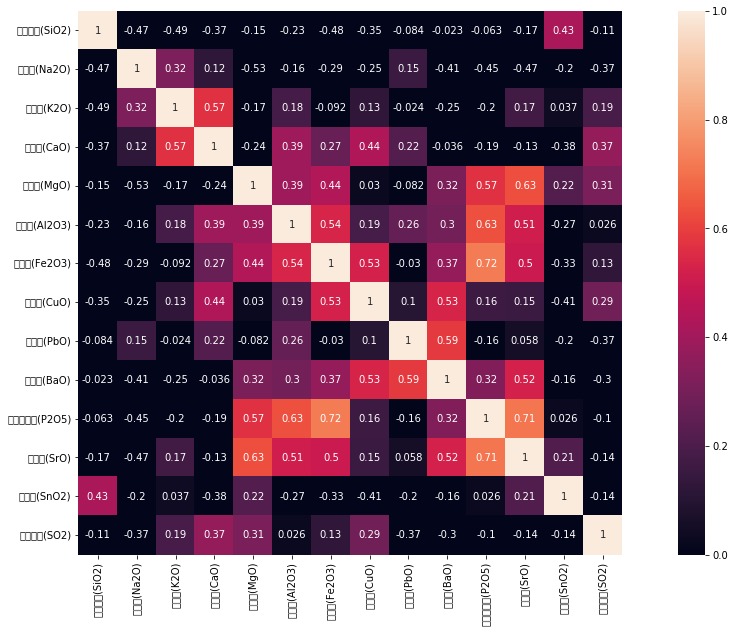

In [15]:
plt.figure(figsize=(20, 10))
sns.heatmap(data_2_type0_f.corr(),vmin=0,vmax=1,square=True,annot=True) 

In [16]:
data_2_type0_uf.corr()

,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2),类型,表面风化
二氧化硅(SiO2),1.000000,NaN,0.606818,-0.897296,-0.641751,-0.868668,0.203514,-0.319337,NaN,NaN,-0.648887,NaN,NaN,NaN,NaN,NaN
氧化钠(Na2O),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
氧化钾(K2O),0.606818,NaN,1.000000,-0.296206,-0.245715,-0.327547,0.749855,-0.639279,NaN,NaN,-0.854634,NaN,NaN,NaN,NaN,NaN
氧化钙(CaO),-0.897296,NaN,-0.296206,1.000000,0.727396,0.957850,0.173456,0.000395,NaN,NaN,0.396647,NaN,NaN,NaN,NaN,NaN
氧化镁(MgO),-0.641751,NaN,-0.245715,0.727396,1.000000,0.892246,0.181322,-0.460397,NaN,NaN,-0.004976,NaN,NaN,NaN,NaN,NaN
氧化铝(Al2O3),-0.868668,NaN,-0.327547,0.957850,0.892246,1.000000,0.153065,-0.164835,NaN,NaN,0.281486,NaN,NaN,NaN,NaN,NaN
氧化铁(Fe2O3),0.203514,NaN,0.749855,0.173456,0.181322,0.153065,1.000000,-0.735278,NaN,NaN,-0.555125,NaN,NaN,NaN,NaN,NaN
氧化铜(CuO),-0.319337,NaN,-0.639279,0.000395,-0.460397,-0.164835,-0.735278,1.000000,NaN,NaN,0.828151,NaN,NaN,NaN,NaN,NaN
氧化铅(PbO),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
氧化钡(BaO),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
del data_2_type0_uf['类型']
del data_2_type0_uf['表面风化']

In [18]:
data_2_type0_uf.corr()

,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2)
二氧化硅(SiO2),1.000000,NaN,0.606818,-0.897296,-0.641751,-0.868668,0.203514,-0.319337,NaN,NaN,-0.648887,NaN,NaN,NaN
氧化钠(Na2O),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
氧化钾(K2O),0.606818,NaN,1.000000,-0.296206,-0.245715,-0.327547,0.749855,-0.639279,NaN,NaN,-0.854634,NaN,NaN,NaN
氧化钙(CaO),-0.897296,NaN,-0.296206,1.000000,0.727396,0.957850,0.173456,0.000395,NaN,NaN,0.396647,NaN,NaN,NaN
氧化镁(MgO),-0.641751,NaN,-0.245715,0.727396,1.000000,0.892246,0.181322,-0.460397,NaN,NaN,-0.004976,NaN,NaN,NaN
氧化铝(Al2O3),-0.868668,NaN,-0.327547,0.957850,0.892246,1.000000,0.153065,-0.164835,NaN,NaN,0.281486,NaN,NaN,NaN
氧化铁(Fe2O3),0.203514,NaN,0.749855,0.173456,0.181322,0.153065,1.000000,-0.735278,NaN,NaN,-0.555125,NaN,NaN,NaN
氧化铜(CuO),-0.319337,NaN,-0.639279,0.000395,-0.460397,-0.164835,-0.735278,1.000000,NaN,NaN,0.828151,NaN,NaN,NaN
氧化铅(PbO),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
氧化钡(BaO),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


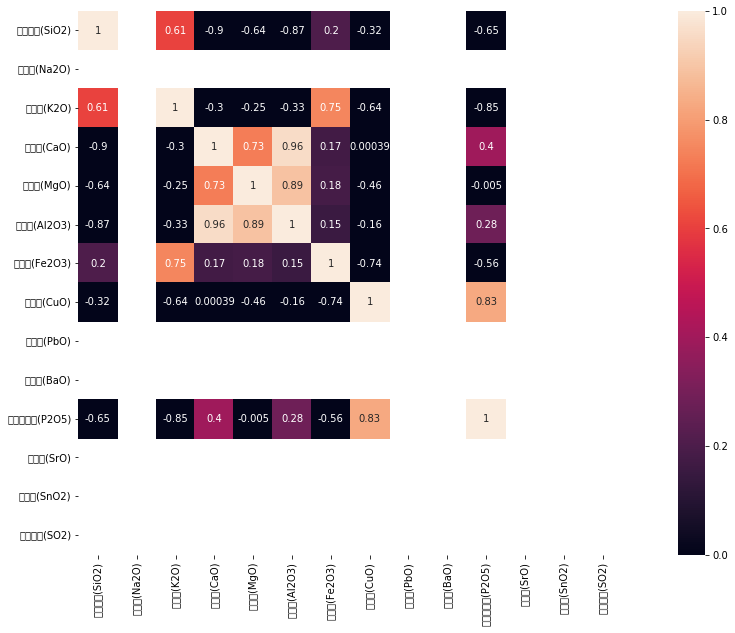

In [19]:
plt.figure(figsize=(20, 10))
sns.heatmap(data_2_type0_uf.corr(),vmin=0,vmax=1,square=True,annot=True) 

In [98]:
data_2_type1_f.corr()

,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2),类型,表面风化
二氧化硅(SiO2),1.000000,-0.000161,-0.421057,-0.445812,0.142477,-0.281190,-0.136104,-0.501356,-0.564599,-0.755667,-0.288638,-0.499416,-0.539230,0.137513,NaN,NaN
氧化钠(Na2O),-0.000161,1.000000,-0.129045,-0.111541,-0.012597,-0.021622,-0.350821,-0.192393,0.080202,-0.090399,-0.263899,0.275333,-0.222296,-0.150697,NaN,NaN
氧化钾(K2O),-0.421057,-0.129045,1.000000,0.421441,0.212380,0.510390,0.164566,-0.051450,0.198033,0.189290,0.201988,-0.035733,0.459751,-0.021480,NaN,NaN
氧化钙(CaO),-0.445812,-0.111541,0.421441,1.000000,0.198820,0.187102,0.556450,-0.348216,0.719357,-0.148959,-0.135822,0.176606,0.950929,-0.070398,NaN,NaN
氧化镁(MgO),0.142477,-0.012597,0.212380,0.198820,1.000000,0.492967,0.167920,-0.431050,0.118699,-0.323092,-0.301419,0.175923,0.196232,-0.271180,NaN,NaN
氧化铝(Al2O3),-0.281190,-0.021622,0.510390,0.187102,0.492967,1.000000,0.256300,-0.107042,-0.168487,0.244888,0.442720,0.014933,0.287552,-0.102945,NaN,NaN
氧化铁(Fe2O3),-0.136104,-0.350821,0.164566,0.556450,0.167920,0.256300,1.000000,-0.220177,0.087988,-0.166594,0.339966,-0.030781,0.463631,-0.193999,NaN,NaN
氧化铜(CuO),-0.501356,-0.192393,-0.051450,-0.348216,-0.431050,-0.107042,-0.220177,1.000000,-0.152116,0.886241,0.344009,0.400868,-0.277030,0.175275,NaN,NaN
氧化铅(PbO),-0.564599,0.080202,0.198033,0.719357,0.118699,-0.168487,0.087988,-0.152116,1.000000,-0.004561,-0.470504,0.400752,0.723766,-0.209920,NaN,NaN
氧化钡(BaO),-0.755667,-0.090399,0.189290,-0.148959,-0.323092,0.244888,-0.166594,0.886241,-0.004561,1.000000,0.460697,0.414097,-0.011339,-0.006884,NaN,NaN


In [20]:
del data_2_type1_f['类型']
del data_2_type1_f['表面风化']

In [100]:
data_2_type1_f.corr()

,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2)
二氧化硅(SiO2),1.000000,-0.000161,-0.421057,-0.445812,0.142477,-0.281190,-0.136104,-0.501356,-0.564599,-0.755667,-0.288638,-0.499416,-0.539230,0.137513
氧化钠(Na2O),-0.000161,1.000000,-0.129045,-0.111541,-0.012597,-0.021622,-0.350821,-0.192393,0.080202,-0.090399,-0.263899,0.275333,-0.222296,-0.150697
氧化钾(K2O),-0.421057,-0.129045,1.000000,0.421441,0.212380,0.510390,0.164566,-0.051450,0.198033,0.189290,0.201988,-0.035733,0.459751,-0.021480
氧化钙(CaO),-0.445812,-0.111541,0.421441,1.000000,0.198820,0.187102,0.556450,-0.348216,0.719357,-0.148959,-0.135822,0.176606,0.950929,-0.070398
氧化镁(MgO),0.142477,-0.012597,0.212380,0.198820,1.000000,0.492967,0.167920,-0.431050,0.118699,-0.323092,-0.301419,0.175923,0.196232,-0.271180
氧化铝(Al2O3),-0.281190,-0.021622,0.510390,0.187102,0.492967,1.000000,0.256300,-0.107042,-0.168487,0.244888,0.442720,0.014933,0.287552,-0.102945
氧化铁(Fe2O3),-0.136104,-0.350821,0.164566,0.556450,0.167920,0.256300,1.000000,-0.220177,0.087988,-0.166594,0.339966,-0.030781,0.463631,-0.193999
氧化铜(CuO),-0.501356,-0.192393,-0.051450,-0.348216,-0.431050,-0.107042,-0.220177,1.000000,-0.152116,0.886241,0.344009,0.400868,-0.277030,0.175275
氧化铅(PbO),-0.564599,0.080202,0.198033,0.719357,0.118699,-0.168487,0.087988,-0.152116,1.000000,-0.004561,-0.470504,0.400752,0.723766,-0.209920
氧化钡(BaO),-0.755667,-0.090399,0.189290,-0.148959,-0.323092,0.244888,-0.166594,0.886241,-0.004561,1.000000,0.460697,0.414097,-0.011339,-0.006884


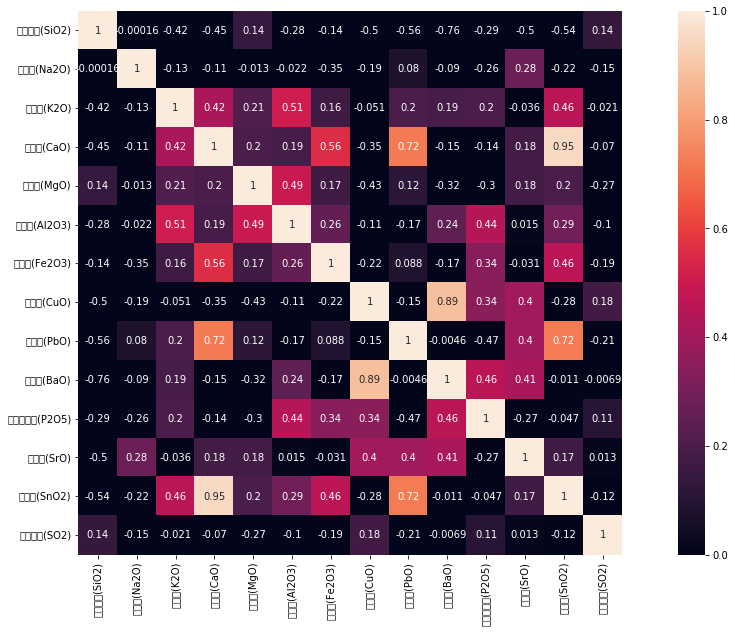

In [101]:
plt.figure(figsize=(20, 10))
sns.heatmap(data_2_type1_f.corr(),vmin=0,vmax=1,square=True,annot=True) 

In [102]:
data_2_type1_uf.corr()

,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2),类型,表面风化
二氧化硅(SiO2),1.000000,0.536641,0.223078,-0.401063,0.190501,0.617580,0.078942,-0.321333,-0.706181,-0.436966,-0.512834,-0.528233,0.211460,-0.448091,NaN,NaN
氧化钠(Na2O),0.536641,1.000000,-0.017857,-0.480460,0.026681,0.114728,-0.218547,-0.026282,-0.481800,-0.049179,-0.475205,-0.233073,-0.055672,-0.139520,NaN,NaN
氧化钾(K2O),0.223078,-0.017857,1.000000,0.031348,0.389371,0.370454,0.298560,-0.197089,-0.173644,-0.162390,-0.108358,-0.158338,0.110317,0.048254,NaN,NaN
氧化钙(CaO),-0.401063,-0.480460,0.031348,1.000000,0.446275,0.106738,0.481239,-0.019340,0.189381,-0.125765,0.569264,0.132051,0.074280,0.094732,NaN,NaN
氧化镁(MgO),0.190501,0.026681,0.389371,0.446275,1.000000,0.449020,0.477029,-0.296297,-0.143148,-0.487755,0.302310,0.033947,0.262829,-0.300393,NaN,NaN
氧化铝(Al2O3),0.617580,0.114728,0.370454,0.106738,0.449020,1.000000,0.334459,-0.332328,-0.556981,-0.412235,-0.148258,-0.218946,0.495748,-0.222742,NaN,NaN
氧化铁(Fe2O3),0.078942,-0.218547,0.298560,0.481239,0.477029,0.334459,1.000000,-0.276889,0.004272,-0.427566,0.294650,-0.113155,0.157887,-0.225910,NaN,NaN
氧化铜(CuO),-0.321333,-0.026282,-0.197089,-0.019340,-0.296297,-0.332328,-0.276889,1.000000,-0.124764,0.681231,0.041149,0.097058,-0.163239,0.258690,NaN,NaN
氧化铅(PbO),-0.706181,-0.481800,-0.173644,0.189381,-0.143148,-0.556981,0.004272,-0.124764,1.000000,-0.176964,0.271278,0.456539,-0.249557,-0.111150,NaN,NaN
氧化钡(BaO),-0.436966,-0.049179,-0.162390,-0.125765,-0.487755,-0.412235,-0.427566,0.681231,-0.176964,1.000000,-0.071398,0.084153,-0.088643,0.711564,NaN,NaN


In [103]:
del data_2_type1_uf['类型']
del data_2_type1_uf['表面风化']

In [104]:
data_2_type1_uf.corr()

,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2)
二氧化硅(SiO2),1.000000,0.536641,0.223078,-0.401063,0.190501,0.617580,0.078942,-0.321333,-0.706181,-0.436966,-0.512834,-0.528233,0.211460,-0.448091
氧化钠(Na2O),0.536641,1.000000,-0.017857,-0.480460,0.026681,0.114728,-0.218547,-0.026282,-0.481800,-0.049179,-0.475205,-0.233073,-0.055672,-0.139520
氧化钾(K2O),0.223078,-0.017857,1.000000,0.031348,0.389371,0.370454,0.298560,-0.197089,-0.173644,-0.162390,-0.108358,-0.158338,0.110317,0.048254
氧化钙(CaO),-0.401063,-0.480460,0.031348,1.000000,0.446275,0.106738,0.481239,-0.019340,0.189381,-0.125765,0.569264,0.132051,0.074280,0.094732
氧化镁(MgO),0.190501,0.026681,0.389371,0.446275,1.000000,0.449020,0.477029,-0.296297,-0.143148,-0.487755,0.302310,0.033947,0.262829,-0.300393
氧化铝(Al2O3),0.617580,0.114728,0.370454,0.106738,0.449020,1.000000,0.334459,-0.332328,-0.556981,-0.412235,-0.148258,-0.218946,0.495748,-0.222742
氧化铁(Fe2O3),0.078942,-0.218547,0.298560,0.481239,0.477029,0.334459,1.000000,-0.276889,0.004272,-0.427566,0.294650,-0.113155,0.157887,-0.225910
氧化铜(CuO),-0.321333,-0.026282,-0.197089,-0.019340,-0.296297,-0.332328,-0.276889,1.000000,-0.124764,0.681231,0.041149,0.097058,-0.163239,0.258690
氧化铅(PbO),-0.706181,-0.481800,-0.173644,0.189381,-0.143148,-0.556981,0.004272,-0.124764,1.000000,-0.176964,0.271278,0.456539,-0.249557,-0.111150
氧化钡(BaO),-0.436966,-0.049179,-0.162390,-0.125765,-0.487755,-0.412235,-0.427566,0.681231,-0.176964,1.000000,-0.071398,0.084153,-0.088643,0.711564


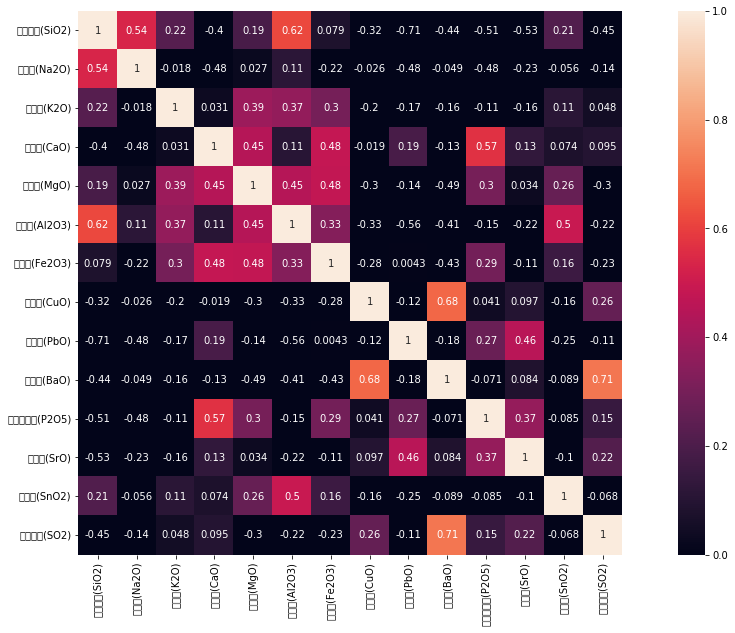

In [105]:
plt.figure(figsize=(20, 10))
sns.heatmap(data_2_type1_uf.corr(),vmin=0,vmax=1,square=True,annot=True) 

In [21]:
data = pd.read_csv('t1.csv')

In [22]:
data['颜色'].unique()

array(['蓝绿', '浅蓝', '紫', '深绿', '深蓝', nan, '浅绿', '黑', '绿'], dtype=object)

In [23]:
data = pd.read_csv('t2.csv')

In [24]:
from mvtpy.mvtest import mvtest
model = mvtest()

In [ ]:
for i in data.columns:
    for j in data.co

In [25]:
model.test(data['二氧化硅(SiO2)'], data['氧化钠(Na2O)'])

{'Tn': 1.51, 'p-value': [0.15, 0.2]}

In [26]:
data

,文物采样点,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2)
0,01,69.33,NaN,9.99,6.32,0.87,3.93,1.74,3.87,NaN,NaN,1.17,NaN,NaN,0.39
1,02,36.28,NaN,1.05,2.34,1.18,5.73,1.86,0.26,47.43,NaN,3.57,0.19,NaN,NaN
2,03部位1,87.05,NaN,5.19,2.01,NaN,4.06,NaN,0.78,0.25,NaN,0.66,NaN,NaN,NaN
3,03部位2,61.71,NaN,12.37,5.87,1.11,5.50,2.16,5.09,1.41,2.86,0.70,0.10,NaN,NaN
4,04,65.88,NaN,9.67,7.12,1.56,6.44,2.06,2.18,NaN,NaN,0.79,NaN,NaN,0.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,54严重风化点,17.11,NaN,NaN,NaN,1.11,3.65,NaN,1.34,58.46,NaN,14.13,1.12,NaN,NaN
65,55,49.01,2.71,NaN,1.13,NaN,1.45,NaN,0.86,32.92,7.95,0.35,NaN,NaN,NaN
66,56,29.15,NaN,NaN,1.21,NaN,1.85,NaN,0.79,41.25,15.45,2.54,NaN,NaN,NaN
67,57,25.42,NaN,NaN,1.31,NaN,2.18,NaN,1.16,45.10,17.30,NaN,NaN,NaN,NaN


In [27]:
del data['文物采样点']

In [28]:
cols = [col for col in data.columns]

In [29]:
data = data.fillna(0)

In [36]:
data

,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2)
0,69.33,0.00,9.99,6.32,0.87,3.93,1.74,3.87,0.00,0.00,1.17,0.00,0.0,0.39
1,36.28,0.00,1.05,2.34,1.18,5.73,1.86,0.26,47.43,0.00,3.57,0.19,0.0,0.00
2,87.05,0.00,5.19,2.01,0.00,4.06,0.00,0.78,0.25,0.00,0.66,0.00,0.0,0.00
3,61.71,0.00,12.37,5.87,1.11,5.50,2.16,5.09,1.41,2.86,0.70,0.10,0.0,0.00
4,65.88,0.00,9.67,7.12,1.56,6.44,2.06,2.18,0.00,0.00,0.79,0.00,0.0,0.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,17.11,0.00,0.00,0.00,1.11,3.65,0.00,1.34,58.46,0.00,14.13,1.12,0.0,0.00
65,49.01,2.71,0.00,1.13,0.00,1.45,0.00,0.86,32.92,7.95,0.35,0.00,0.0,0.00
66,29.15,0.00,0.00,1.21,0.00,1.85,0.00,0.79,41.25,15.45,2.54,0.00,0.0,0.00
67,25.42,0.00,0.00,1.31,0.00,2.18,0.00,1.16,45.10,17.30,0.00,0.00,0.0,0.00


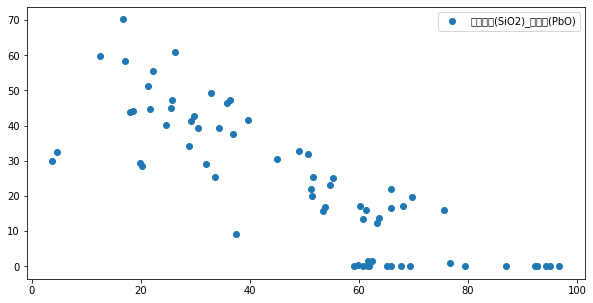

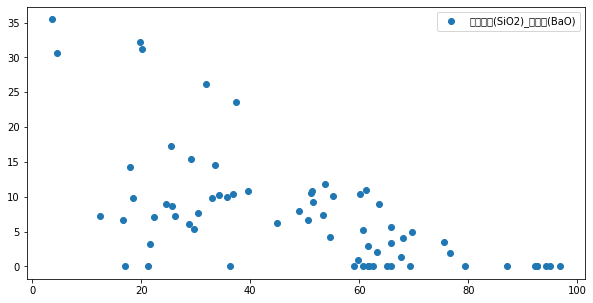

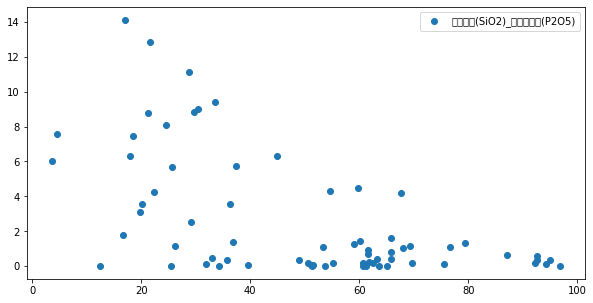

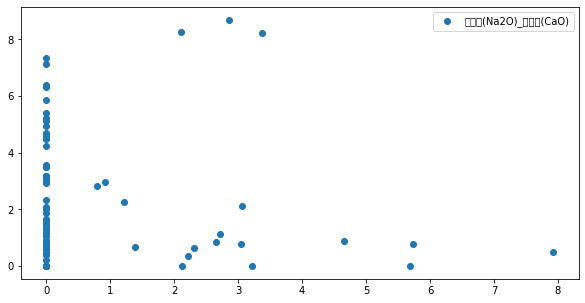

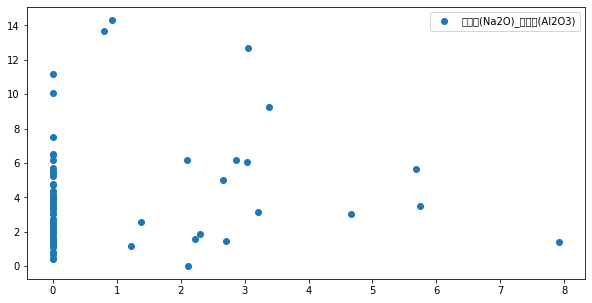

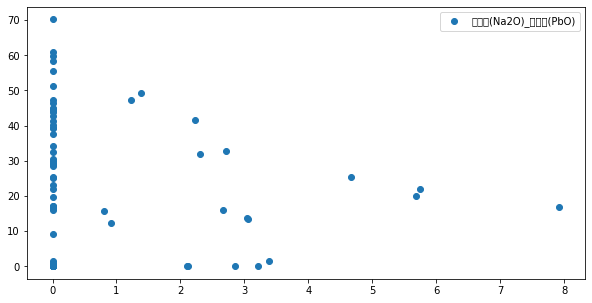

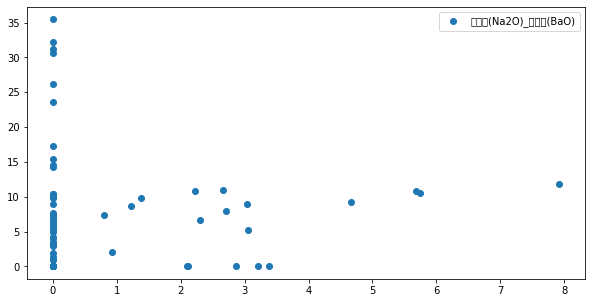

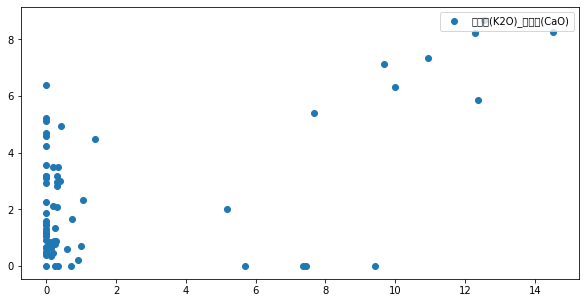

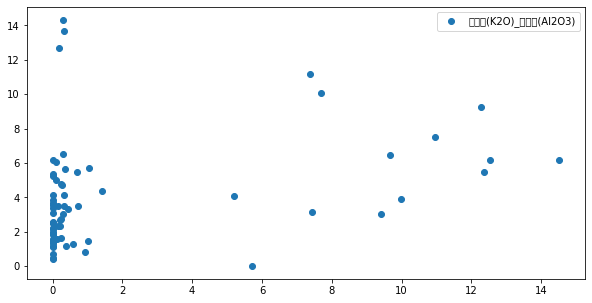

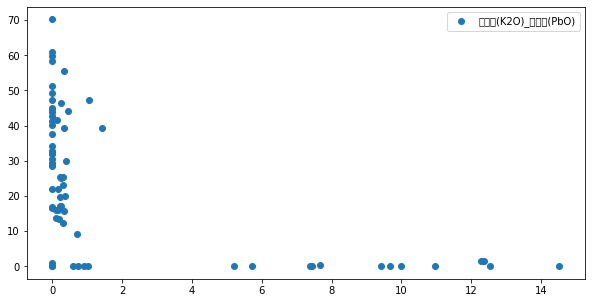

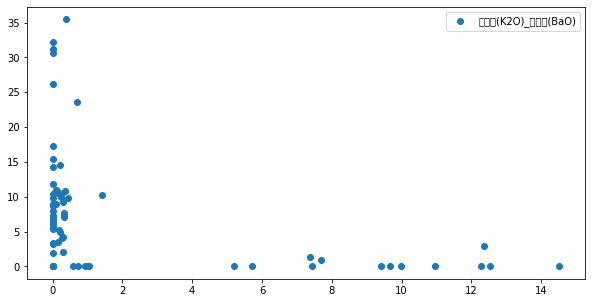

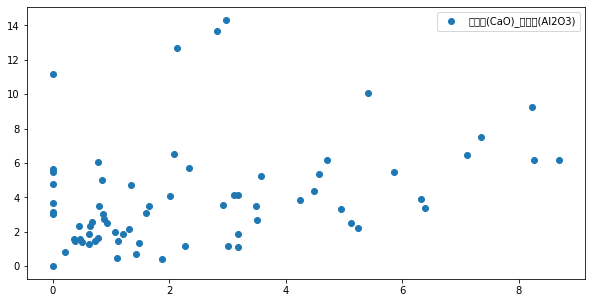

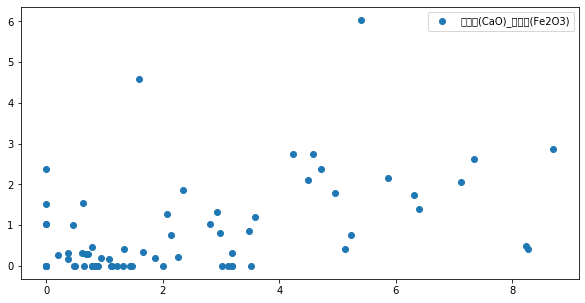

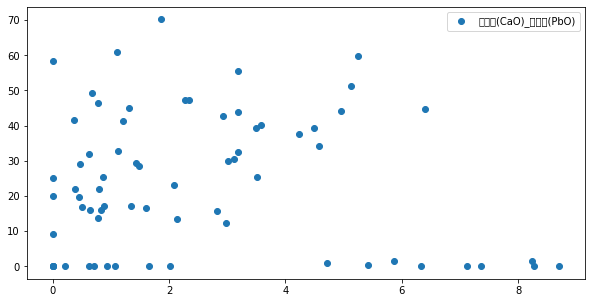

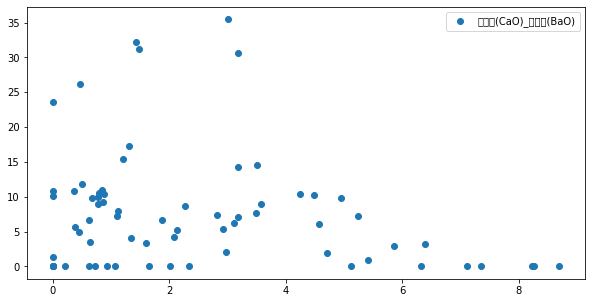

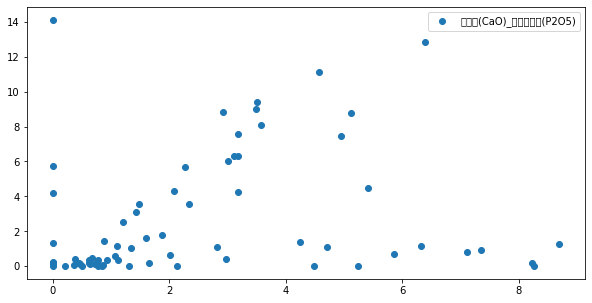

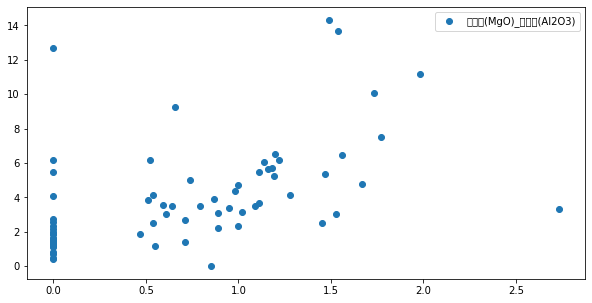

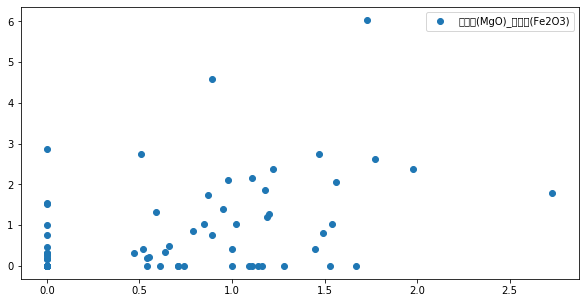

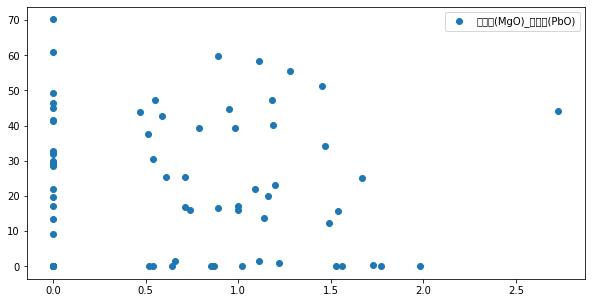

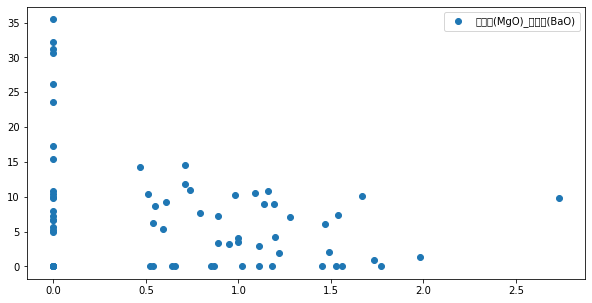

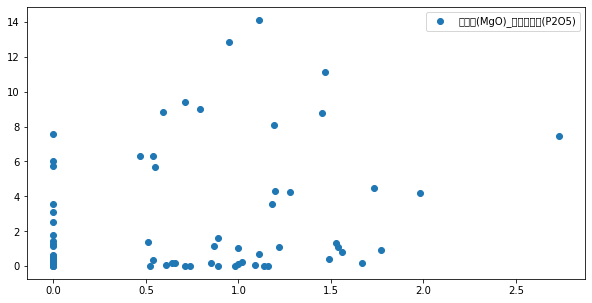

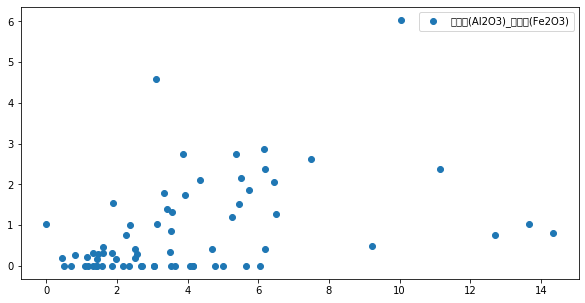

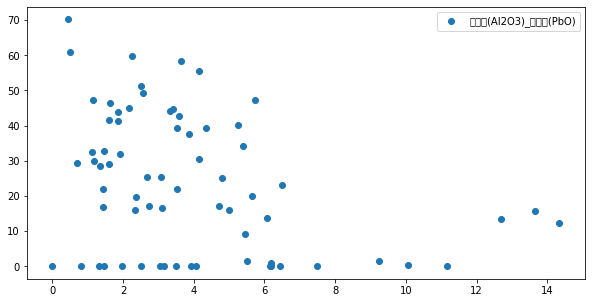

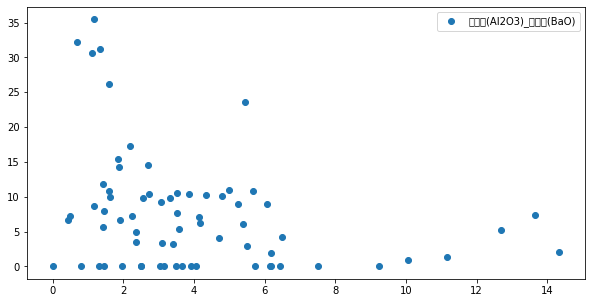

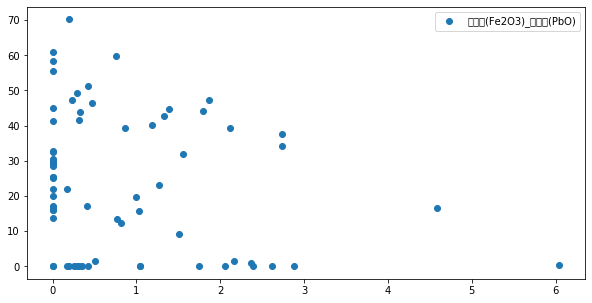

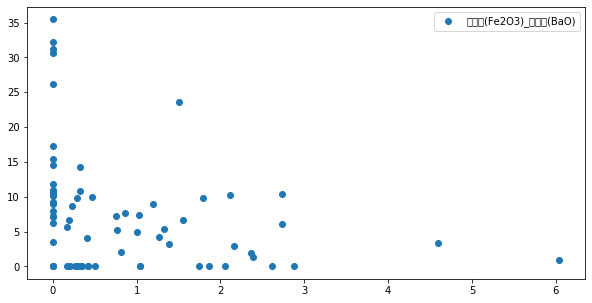

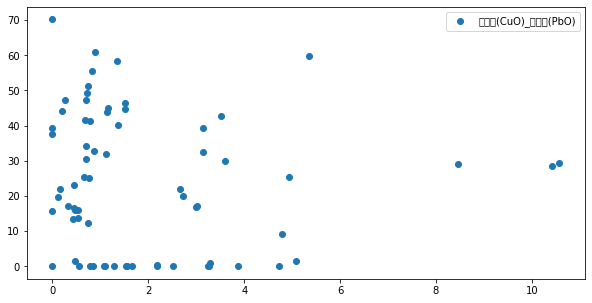

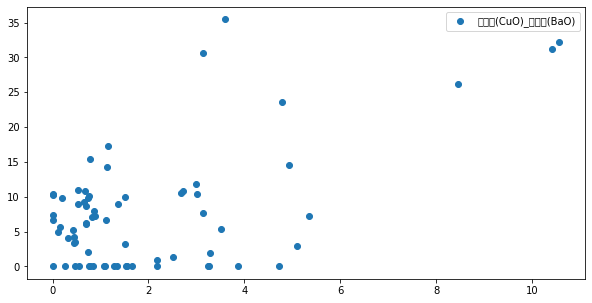

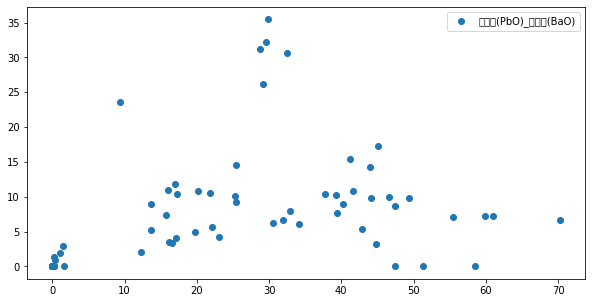

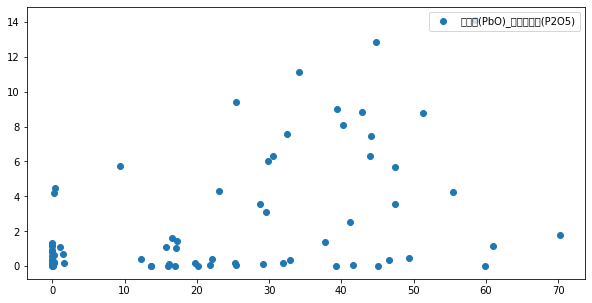

In [33]:
for i in range(14):
    for j in range(i+1,14):
        tmp = model.test(data[cols[i]], data[cols[j]])
        ls_tmp = model._quantiles_transformer(tmp['Tn'])
#         print(tmp)
#         print(ls_tmp)
        if ls_tmp[1] <= 0.01:
            plt.figure(figsize = (10,5))
#             plt.plot(data[cols[i]],data[cols[j]], 'ro-', color='#4169E1', alpha=0.8, linewidth=1, label=cols[i]+'_'+cols[j])
            plt.scatter(data[cols[i]],data[cols[j]],label = cols[i]+"_"+cols[j])
            plt.legend(loc="upper right")
            plt.savefig("D:/Desktop/数模gs/CUMCM2022Problems/C题/no4_picture/总体/总体{}_{}.png".format(cols[i],cols[j]))
#         dep_dict.append(model.test(data[cols[i]], data[cols[j]]))
        

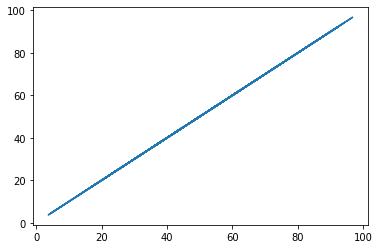

In [26]:
plt.plot(data['二氧化硅(SiO2)'], data['二氧化硅(SiO2)'])

In [ ]:
# data_2_type0_f = data_2_type0[data_2['表面风化']==0]

In [ ]:
del data_t['文物采样点']

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
D_data = data_t
weidu = 14
down_data = np.array(data_t)
km = KMeans(n_clusters=3).fit(down_data)  # 确定完取几类之后开始计算

print("质心")
center = km.cluster_centers_
print(center)
D_data["cluster"] = km.labels_  # 给数据打上聚类标签
print(D_data)

    